<a href="https://colab.research.google.com/github/durashones/Sarcasm-in-Yoruba/blob/main/sarcasm_detection_in_yoruba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip uninstall numpy scipy scikit-learn -y
%pip install numpy scipy scikit-learn

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.1
Uninstalling scipy-1.16.1:
  Successfully uninstalled scipy-1.16.1
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 67.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but y

In [ ]:
!nvidia-smi
import torch; print("CUDA:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Sat Sep  6 02:35:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q --upgrade transformers datasets accelerate evaluate torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
import transformers
print(transformers.__version__)

from transformers import TrainingArguments
print(help(TrainingArguments))

4.56.1
Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_ut

In [ ]:
%pip install evaluate

In [ ]:
import pandas as pd
import numpy as np

# If uploading manually via the file picker:
from google.colab import files
uploaded = files.upload()  # upload your 'yoruba_only_minimal.csv' (or similar)

# Read
df = pd.read_csv(next(iter(uploaded.keys())))
df.head()



Saving yoruba_only_minimal.csv to yoruba_only_minimal.csv


,text,final_label
0,mákaànjúolá early morning freestyle àkànó akéw...,INDETERMINATE
1,òjò dúdú bọ̀lọ̀jọ̀,NEUTRAL
2,ẹkùn alábẹlọ́wọ́ náà ó fi bẹ́ẹ̀ kùn nínú igbó ...,NEGATIVE
3,ìyáàfin kemi ariyo eni sọbe iro lopa oh,NEGATIVE
4,its a year throw back video o ya o a tún gbedé...,NEUTRAL


In [ ]:
import unicodedata, re
from sklearn.model_selection import train_test_split

def normalize_nfc(text):
    # Keep Yorùbá diacritics but normalize form
    return unicodedata.normalize("NFC", str(text))

def basic_clean(text):
    text = normalize_nfc(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df = df.dropna(subset=["text", "final_label"]).copy()
df["text"] = df["text"].apply(basic_clean)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["final_label"])
print("Classes:", list(le.classes_))

# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label_id"])
len(train_df), len(test_df)


Classes: ['INDETERMINATE', 'MIXED', 'NEGATIVE', 'NEUTRAL', 'POSITIVE']


(19953, 4989)

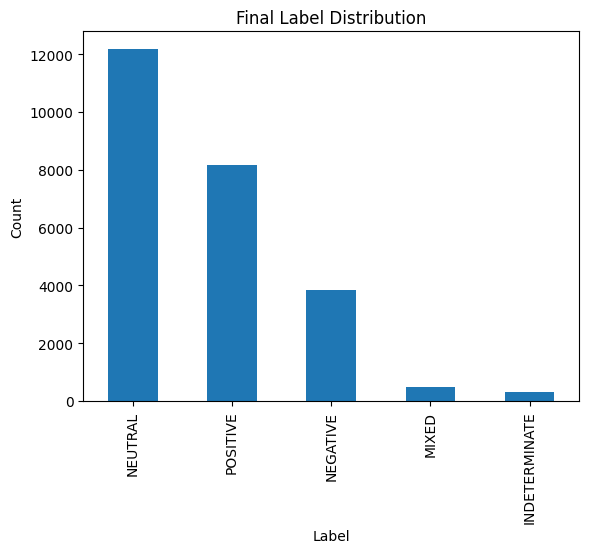

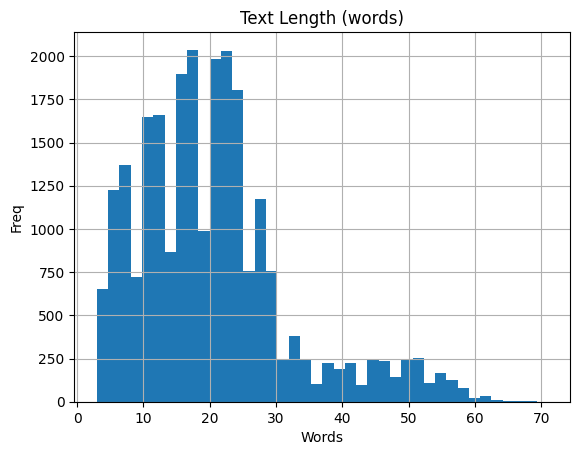

In [ ]:
import matplotlib.pyplot as plt

ax = df["final_label"].value_counts().plot(kind="bar")
ax.set_title("Final Label Distribution")
ax.set_xlabel("Label"); ax.set_ylabel("Count")
plt.show()

df["len_words"] = df["text"].str.split().apply(len)
df["len_words"].hist(bins=40)
plt.title("Text Length (words)"); plt.xlabel("Words"); plt.ylabel("Freq")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

X_train_text = train_df["text"].tolist()
y_train = train_df["label_id"].values
X_test_text  = test_df["text"].tolist()
y_test  = test_df["label_id"].values

tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
X_train = tfidf.fit_transform(X_train_text)
X_test  = tfidf.transform(X_test_text)

results = {}

# 1) Logistic Regression
lr = LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=-1)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
results["LogReg"] = classification_report(y_test, pred_lr, target_names=le.classes_, output_dict=True)
print("Logistic Regression\n", classification_report(y_test, pred_lr, target_names=le.classes_))

# 2) Linear SVM
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
results["LinearSVM"] = classification_report(y_test, pred_svm, target_names=le.classes_, output_dict=True)
print("Linear SVM\n", classification_report(y_test, pred_svm, target_names=le.classes_))

# 3) Multinomial NB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
pred_mnb = mnb.predict(X_test)
results["MultinomialNB"] = classification_report(y_test, pred_mnb, target_names=le.classes_, output_dict=True)
print("Multinomial Naive Bayes\n", classification_report(y_test, pred_mnb, target_names=le.classes_))

# 4) Random Forest
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight="balanced_subsample", random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
results["RandomForest"] = classification_report(y_test, pred_rf, target_names=le.classes_, output_dict=True)
print("Random Forest\n", classification_report(y_test, pred_rf, target_names=le.classes_))


Logistic Regression
                precision    recall  f1-score   support

INDETERMINATE       0.30      0.66      0.41        59
        MIXED       0.22      0.28      0.25        95
     NEGATIVE       0.49      0.67      0.56       767
      NEUTRAL       0.80      0.69      0.74      2437
     POSITIVE       0.76      0.72      0.74      1631

     accuracy                           0.69      4989
    macro avg       0.51      0.61      0.54      4989
 weighted avg       0.72      0.69      0.70      4989

Linear SVM
                precision    recall  f1-score   support

INDETERMINATE       0.60      0.44      0.51        59
        MIXED       0.28      0.20      0.23        95
     NEGATIVE       0.56      0.56      0.56       767
      NEUTRAL       0.76      0.79      0.78      2437
     POSITIVE       0.76      0.73      0.75      1631

     accuracy                           0.72      4989
    macro avg       0.59      0.55      0.57      4989
 weighted avg       0.72   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Random Forest
                precision    recall  f1-score   support

INDETERMINATE       0.75      0.31      0.43        59
        MIXED       0.36      0.11      0.16        95
     NEGATIVE       0.78      0.18      0.30       767
      NEUTRAL       0.63      0.93      0.75      2437
     POSITIVE       0.82      0.59      0.68      1631

     accuracy                           0.68      4989
    macro avg       0.67      0.42      0.47      4989
 weighted avg       0.71      0.68      0.65      4989



In [ ]:
import random, numpy as np, torch
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


In [ ]:
# 🤖 STEP 5 — Transformers (now 4 models, incl. mBERT cased)

import torch, numpy as np, evaluate
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from sklearn.metrics import classification_report

id2label = {i: lab for i, lab in enumerate(le.classes_)}
label2id = {lab: i for i, lab in enumerate(le.classes_)}

train_ds = Dataset.from_pandas(train_df[["text","label_id"]].rename(columns={"label_id":"labels"}), preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]].rename(columns={"label_id":"labels"}), preserve_index=False)

def run_transformer(model_name, epochs=3, batch_size=16, lr=5e-5, max_len=128):
    print(f"\n=== Fine-tuning {model_name} ===")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tok_fn(batch):
        return tokenizer(batch["text"], truncation=True, max_length=max_len)

    tokenized_train = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
    tokenized_test  = test_ds.map(tok_fn, batched=True, remove_columns=["text"])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    f1 = evaluate.load("f1")
    acc = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(le.classes_),
        id2label=id2label, label2id=label2id
    )

    args = TrainingArguments(
        output_dir=f"./{model_name.split('/')[-1]}-yoruba-sentiment",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model, args=args,
        train_dataset=tokenized_train, eval_dataset=tokenized_test,
        tokenizer=tokenizer, data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Detailed report
    preds = trainer.predict(tokenized_test)
    y_pred = preds.predictions.argmax(axis=-1)
    print(classification_report(test_df["label_id"], y_pred, target_names=le.classes_))

    return trainer, tokenizer

# Run all four models (incl. mBERT cased)
model_names = [
    "xlm-roberta-base",
    "Davlan/afro-xlmr-base",
    "castorini/afriberta_base",
    "bert-base-multilingual-cased"   # <= mBERT (CASED) for Yorùbá diacritics
]

trained = {}
for m in model_names:
    trainer, tok = run_transformer(m, epochs=3, batch_size=16, lr=5e-5, max_len=128)
    trained[m] = (trainer, tok)



=== Fine-tuning xlm-roberta-base ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1389485652.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.187700,1.134892,0.488475,0.131269
2,1.100000,1.134876,0.488475,0.131269
3,1.128300,1.131813,0.488475,0.131269


               precision    recall  f1-score   support

INDETERMINATE       0.00      0.00      0.00        59
        MIXED       0.00      0.00      0.00        95
     NEGATIVE       0.00      0.00      0.00       767
      NEUTRAL       0.49      1.00      0.66      2437
     POSITIVE       0.00      0.00      0.00      1631

     accuracy                           0.49      4989
    macro avg       0.10      0.20      0.13      4989
 weighted avg       0.24      0.49      0.32      4989


=== Fine-tuning Davlan/afro-xlmr-base ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1389485652.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.950400,0.848550,0.664863,0.426165
2,0.745600,0.767577,0.702946,0.490721
3,0.629200,0.771028,0.711966,0.517396


               precision    recall  f1-score   support

INDETERMINATE       0.64      0.51      0.57        59
        MIXED       0.00      0.00      0.00        95
     NEGATIVE       0.52      0.49      0.50       767
      NEUTRAL       0.75      0.78      0.76      2437
     POSITIVE       0.75      0.76      0.75      1631

     accuracy                           0.71      4989
    macro avg       0.53      0.51      0.52      4989
 weighted avg       0.70      0.71      0.70      4989


=== Fine-tuning castorini/afriberta_base ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1389485652.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.847600,0.723084,0.723191,0.518040
2,0.567600,0.716975,0.744037,0.535034
3,0.321000,0.881695,0.739026,0.572515


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

               precision    recall  f1-score   support

INDETERMINATE       0.62      0.44      0.51        59
        MIXED       0.28      0.16      0.20        95
     NEGATIVE       0.61      0.59      0.60       767
      NEUTRAL       0.77      0.81      0.79      2437
     POSITIVE       0.77      0.76      0.76      1631

     accuracy                           0.74      4989
    macro avg       0.61      0.55      0.57      4989
 weighted avg       0.73      0.74      0.74      4989


=== Fine-tuning bert-base-multilingual-cased ===


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1389485652.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.989800,0.876500,0.654039,0.415160
2,0.759500,0.787266,0.698537,0.482151
3,0.603400,0.814183,0.699539,0.511514


               precision    recall  f1-score   support

INDETERMINATE       0.65      0.56      0.60        59
        MIXED       1.00      0.01      0.02        95
     NEGATIVE       0.51      0.40      0.44       767
      NEUTRAL       0.73      0.80      0.76      2437
     POSITIVE       0.72      0.73      0.73      1631

     accuracy                           0.70      4989
    macro avg       0.72      0.50      0.51      4989
 weighted avg       0.70      0.70      0.69      4989



In [ ]:
samples = [
    "Ìfẹ́ yìí dùn mí gan-an.",         # positive
    "Èyí burú ju béè lọ.",             # negative
    "Ó dàbí ẹni pé kò ṣe kankan.",     # neutral/indeterminate
    "Ọja náà dáa ṣùgbọ́n iye rè ga.",   # mixed
]

def predict_text(trainer, tokenizer, texts):
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        # Ensure the model is on the correct device
        device = trainer.model.device if hasattr(trainer.model, 'device') else 'cpu'
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = trainer.model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = probs.argmax(axis=-1)
    return [(t, id2label[p], probs[i][p]) for i,(t,p) in enumerate(zip(texts, preds))]

# Ensure the 'trained' dictionary and 'id2label' are defined by running the preceding training cell (a-TKKM3dAQHV)

if 'trained' in globals() and 'id2label' in globals():
    print("XLM-R predictions:")
    # Accessing trainer and tokenizer from the 'trained' dictionary
    if "xlm-roberta-base" in trained:
        trainer_xlmr, tok_xlmr = trained["xlm-roberta-base"]
        for t, lab, conf in predict_text(trainer_xlmr, tok_xlmr, samples):
            print(f"- {t} -> {lab} ({conf:.2f})")
    else:
        print("XLM-R model not found in trained models.")


    print("\nAfroXLM-R predictions:")
    # Accessing trainer and tokenizer from the 'trained' dictionary
    if "Davlan/afroxlmr-base" in trained:
        trainer_afro, tok_afro = trained["Davlan/afroxlmr-base"]
        for t, lab, conf in predict_text(trainer_afro, tok_afro, samples):
            print(f"- {t} -> {lab} ({conf:.2f})")
    else:
        print("AfroXLM-R model not found in trained models.")


    print("\nAfriBERTa predictions:")
    # Accessing trainer and tokenizer from the 'trained' dictionary
    if "castorini/afriberta_base" in trained:
        trainer_afriberta, tok_afriberta = trained["castorini/afriberta_base"]
        for t, lab, conf in predict_text(trainer_afriberta, tok_afriberta, samples):
            print(f"- {t} -> {lab} ({conf:.2f})")
    else:
         print("AfriBERTa model not found in trained models.")


    print("\nmBERT predictions:")
    # Accessing trainer and tokenizer from the 'trained' dictionary
    if "bert-base-multilingual-cased" in trained:
        trainer_mbert, tok_mbert = trained["bert-base-multilingual-cased"]
        for t, lab, conf in predict_text(trainer_mbert, tok_mbert, samples):
            print(f"- {t} -> {lab} ({conf:.2f})")
    else:
        print("mBERT model not found in trained models.")

else:
    print("Please run the preceding transformer training cell (a-TKKM3dAQHV) first to define 'trained' and 'id2label'.")

XLM-R predictions:
- Ìfẹ́ yìí dùn mí gan-an. -> NEUTRAL (0.49)
- Èyí burú ju béè lọ. -> NEUTRAL (0.49)
- Ó dàbí ẹni pé kò ṣe kankan. -> NEUTRAL (0.49)
- Ọja náà dáa ṣùgbọ́n iye rè ga. -> NEUTRAL (0.49)

AfroXLM-R predictions:
AfroXLM-R model not found in trained models.

AfriBERTa predictions:
- Ìfẹ́ yìí dùn mí gan-an. -> POSITIVE (0.58)
- Èyí burú ju béè lọ. -> NEUTRAL (0.88)
- Ó dàbí ẹni pé kò ṣe kankan. -> NEGATIVE (0.55)
- Ọja náà dáa ṣùgbọ́n iye rè ga. -> NEUTRAL (0.62)

mBERT predictions:
- Ìfẹ́ yìí dùn mí gan-an. -> POSITIVE (0.96)
- Èyí burú ju béè lọ. -> NEGATIVE (0.52)
- Ó dàbí ẹni pé kò ṣe kankan. -> NEGATIVE (0.57)
- Ọja náà dáa ṣùgbọ́n iye rè ga. -> POSITIVE (0.70)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/yoruba_sentiment_best"

# Check if the AfroXLM-R model was trained and exists in the 'trained' dictionary
afro_model_name = "Davlan/afro-xlmr-base"
if afro_model_name in trained:
    trainer_afro, tok_afro = trained[afro_model_name]
    trainer_afro.model.save_pretrained(save_dir)
    tok_afro.save_pretrained(save_dir)
    print("Saved", afro_model_name, "to:", save_dir)
else:
    print(f"Model '{afro_model_name}' was not trained or not found in the 'trained' dictionary.")
    print("Please ensure cell a-TKKM3dAQHV ran successfully and this model was included in the training list.")

Mounted at /content/drive
Saved Davlan/afro-xlmr-base to: /content/drive/MyDrive/yoruba_sentiment_best


In [ ]:
import re
import pandas as pd
import numpy as np

# df must have columns: text, final_label, label_id (from your earlier steps)
# We'll create a new column: sarcasm_soft (float in [0,1])

POS_PAT = r"(dáa|dára|ẹlẹ́wà|ayọ̀|fẹ́ràn|ọ̀rẹ́|ìfẹ́|ire|ìbùkún)"
NEG_PAT = r"(burú|kò\s*dara|ìṣòro|kò\s*ṣiṣẹ́?|ìbànújẹ|ìbínú|ìfarapa|ìṣekúṣe|ìbànilẹ́rìn)"
NEG_EVENT = r"(kò\s*ṣiṣẹ́|jẹ́ kí|ìṣòro|kọlù|ṣòro|ṣìṣe|parí|ìparun|kọjá|jẹ̀yọ)"

HYPERBOLE = r"([A-Z]{2,}|!{2,}|\?{2,}|\.{3,})"
QUOTED_PRAISE_THEN_COMPLAINT = r"\"[^\"]+\".*(" + NEG_PAT + r"|" + NEG_EVENT + r")"
SARC_HASHTAG = r"#sarcasm|#irony|#sarcastic"

def sarcasm_score(t):
    t0 = str(t)
    t_low = t0.lower()

    votes = 0
    weights = 0.0

    # polarity incongruity (positive lexemes + negative context)
    inc = bool(re.search(POS_PAT, t_low) and (re.search(NEG_PAT, t_low) or re.search(NEG_EVENT, t_low)))
    votes += 1 if inc else 0; weights += 0.45 if inc else 0

    # punctuation / hyperbole / all-caps
    hyp = bool(re.search(HYPERBOLE, t0))
    votes += 1 if hyp else 0; weights += 0.15 if hyp else 0

    # quoted praise followed by complaint
    qp = bool(re.search(QUOTED_PRAISE_THEN_COMPLAINT, t_low))
    votes += 1 if qp else 0; weights += 0.25 if qp else 0

    # explicit hashtags (very strong)
    tag = bool(re.search(SARC_HASHTAG, t_low))
    votes += 1 if tag else 0; weights += 0.80 if tag else 0

    # soften into [0,1] using a squashing function
    base = min(weights, 1.0)
    # small boost if multiple cues fire
    if votes >= 2: base = min(1.0, base + 0.15)
    if votes >= 3: base = min(1.0, base + 0.10)
    return float(base)

df = df.copy()
df["sarcasm_soft"] = df["text"].apply(sarcasm_score)

# (Optional) Inspect distribution
df["sarcasm_soft"].describe()


,sarcasm_soft
count,24942.000000
mean,0.002436
std,0.033017
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.450000


In [ ]:
from datasets import Dataset

train_df["sarcasm_soft"] = train_df["text"].apply(sarcasm_score)
test_df["sarcasm_soft"]  = test_df["text"].apply(sarcasm_score)

train_ds = Dataset.from_pandas(train_df[["text","label_id","sarcasm_soft"]].rename(
    columns={"label_id":"labels"}), preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["text","label_id","sarcasm_soft"]].rename(
    columns={"label_id":"labels"}), preserve_index=False)


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AutoTokenizer, PreTrainedModel

backbone_name = "Davlan/afro-xlmr-base"  # or "xlm-roberta-base" / "castorini/afriberta_base" / "bert-base-multilingual-cased"

num_labels = len(le.classes_)
id2label = {i: lab for i, lab in enumerate(le.classes_)}
label2id = {lab: i for i, lab in enumerate(le.classes_)}

config = AutoConfig.from_pretrained(backbone_name)
config.num_labels = num_labels
config.id2label = id2label
config.label2id = label2id

class MTForSentimentSarcasm(PreTrainedModel):
    config_class = AutoConfig
    def __init__(self, config, backbone_name):
        super().__init__(config)
        self.backbone = AutoModel.from_pretrained(backbone_name, config=config)
        hid = self.backbone.config.hidden_size

        # sentiment head (supervised)
        self.drop = nn.Dropout(0.1)
        self.sent_head = nn.Linear(hid, config.num_labels)

        # sarcasm head (binary)
        self.sarc_head = nn.Linear(hid, 1)

        self.ce = nn.CrossEntropyLoss()
        self.bce = nn.BCEWithLogitsLoss()

        # multitask weights
        self.lambda_sarc = 0.5  # you can tune 0.3–1.0

        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, labels=None, sarcasm_soft=None, step=None, total_steps=None, **kwargs):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        # CLS/token 0 for pooled representation (works for XLM-R/mBERT/AfriBERTa)
        h = out.last_hidden_state[:, 0, :]  # [batch, hid]
        h = self.drop(h)

        logits_sent = self.sent_head(h)        # [batch, num_labels]
        logits_sarc = self.sarc_head(h).squeeze(-1)  # [batch]

        loss = None
        loss_sent = None
        loss_sarc = None

        if labels is not None:
            loss_sent = self.ce(logits_sent, labels)

        if sarcasm_soft is not None:
            # sarcasm_soft is float32 in [0,1]
            loss_sarc = self.bce(logits_sarc, sarcasm_soft)

        if (loss_sent is not None) and (loss_sarc is not None):
            # linear ramp for auxiliary weight in first half training
            if (step is not None) and (total_steps is not None) and total_steps > 0:
                progress = min(1.0, step / max(1, total_steps//2))
            else:
                progress = 1.0
            loss = loss_sent + self.lambda_sarc * progress * loss_sarc
        elif loss_sent is not None:
            loss = loss_sent
        else:
            loss = None

        return {"loss": loss, "logits": logits_sent, "logits_sarc": logits_sarc,
                "loss_sent": loss_sent, "loss_sarc": loss_sarc}

tokenizer = AutoTokenizer.from_pretrained(backbone_name)

def tok_fn(batch):
    enc = tokenizer(batch["text"], truncation=True, max_length=128)
    enc["sarcasm_soft"] = batch["sarcasm_soft"]
    return enc

tok_train = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
tok_test  = test_ds.map(tok_fn,  batched=True, remove_columns=["text"])


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

In [ ]:
# ===========================
# STEP 0: Runtime & installs
# ===========================
# In Colab: Runtime > Change runtime type > GPU
!nvidia-smi || echo "No GPU detected."
!pip install -q --upgrade transformers datasets accelerate evaluate torch torchvision torchaudio

# ===========================
# STEP 1: Imports & seed
# ===========================
import os, math, random, re, unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score # Import here for eval_multitask_on_st

import evaluate
from datasets import Dataset
from transformers import (
    AutoConfig, AutoTokenizer, AutoModel, PreTrainedModel,
    DataCollatorWithPadding, TrainingArguments, Trainer
)

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ===========================
# STEP 2: Load your dataset
# ===========================
# Upload in Colab sidebar or via the file picker in the left sidebar, then set the filename here:
# from google.colab import files; files.upload()
CSV_FILE = "yoruba_only_minimal.csv"  # change if needed

df = pd.read_csv(CSV_FILE)
assert {"text","final_label"}.issubset(df.columns), "CSV must have columns: text, final_label"
df = df.dropna(subset=["text","final_label"]).copy()

# ===========================
# STEP 3: Light normalization
# ===========================
def normalize_nfc(s): return unicodedata.normalize("NFC", str(s))
def basic_clean(s):
    s = normalize_nfc(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df["text"].apply(basic_clean)

# ===========================
# STEP 4: Encode labels & split
# ===========================
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["final_label"])
print("Classes:", list(le.classes_))

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=seed, stratify=df["label_id"]
)
print("Train/Test sizes:", len(train_df), len(test_df))

# =========================================
# STEP 5: Heuristic sarcasm soft supervision
# =========================================
POS_PAT = r"(dáa|dára|ẹlẹ́wà|ayọ̀|fẹ́ràn|ọ̀rẹ́|ìfẹ́|ire|ìbùkún)"
NEG_PAT = r"(burú|kò\s*dara|ìṣòro|kò\s*ṣiṣẹ́?|ìbànújẹ|ìbínú|ìfarapa|ìṣekúṣe|ìbànilẹ́rìn)"
NEG_EVENT = r"(kò\s*ṣiṣẹ́|jẹ́ kí|ìṣòro|kọlù|ṣòro|ṣìṣe|parí|ìparun|kọjá|jẹ̀yọ)"
HYPERBOLE = r"([A-Z]{2,}|!{2,}|\?{2,}|\.{3,})"
QUOTED_PRAISE_THEN_COMPLAINT = r"\"[^\"]+\".*(" + NEG_PAT + r"|" + NEG_EVENT + r")"
SARC_HASHTAG = r"#sarcasm|#irony|#sarcastic"

def sarcasm_score(t: str) -> float:
    t0 = str(t)
    t_low = t0.lower()
    votes = 0
    w = 0.0
    inc = bool(re.search(POS_PAT, t_low) and (re.search(NEG_PAT, t_low) or re.search(NEG_EVENT, t_low)))
    if inc: votes += 1; w += 0.45
    hyp = bool(re.search(HYPERBOLE, t0))
    if hyp: votes += 1; w += 0.15
    qp = bool(re.search(QUOTED_PRAISE_THEN_COMPLAINT, t_low))
    if qp: votes += 1; w += 0.25
    tag = bool(re.search(SARC_HASHTAG, t_low))
    if tag: votes += 1; w += 0.80
    base = min(w, 1.0)
    if votes >= 2: base = min(1.0, base + 0.15)
    if votes >= 3: base = min(1.0, base + 0.10)
    return float(base)

train_df = train_df.copy()
test_df  = test_df.copy()
train_df["sarcasm_soft"] = train_df["text"].apply(sarcasm_score)
test_df["sarcasm_soft"]  = test_df["text"].apply(sarcasm_score)
print(train_df["sarcasm_soft"].describe())

# ====================================
# STEP 6: Build HF Datasets & tokenizer
# ====================================
id2label = {i: lab for i, lab in enumerate(le.classes_)}
label2id = {lab: i for i, lab in enumerate(le.classes_)}

train_ds = Dataset.from_pandas(train_df[["text","label_id","sarcasm_soft"]].rename(columns={"label_id":"labels"}), preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["text","label_id","sarcasm_soft"]].rename(columns={"label_id":"labels"}), preserve_index=False)

# Choose one backbone:
# "xlm-roberta-base" | "Davlan/afro-xlmr-base" | "castorini/afriberta_base" | "bert-base-multilingual-cased"
# Using a smaller model to address OOM
backbone_name = "microsoft/xtremedistil-l6-h256-uncased"

tokenizer = AutoTokenizer.from_pretrained(backbone_name)

def tok_fn(batch):
    enc = tokenizer(batch["text"], truncation=True, max_length=128)
    enc["sarcasm_soft"] = batch["sarcasm_soft"]
    return enc

tok_train = train_ds.map(tok_fn, batched=True, remove_columns=["text"])
tok_test  = test_ds.map(tok_fn,  batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ==========================================
# STEP 7: Multitask model (sentiment + sarcasm)
# ==========================================
config = AutoConfig.from_pretrained(backbone_name)
config.num_labels = len(le.classes_)
config.id2label = id2label
config.label2id = label2id

class MTForSentimentSarcasm(PreTrainedModel):
    config_class = AutoConfig
    def __init__(self, config, backbone_name):
        super().__init__(config)
        self.backbone = AutoModel.from_pretrained(backbone_name, config=config)
        hid = self.backbone.config.hidden_size
        self.drop = nn.Dropout(0.1)

        # Heads
        self.sent_head = nn.Linear(hid, config.num_labels)  # supervised sentiment
        self.sarc_head = nn.Linear(hid, 1)                  # auxiliary sarcasm

        # Losses
        self.ce  = nn.CrossEntropyLoss()
        self.bce = nn.BCEWithLogitsLoss()

        # Weight for sarcasm auxiliary loss
        self.lambda_sarc = 0.5

        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, labels=None,
                sarcasm_soft=None, step=None, total_steps=None, **kwargs):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        h = out.last_hidden_state[:, 0, :]  # CLS token
        h = self.drop(h)

        logits_sent = self.sent_head(h)          # [B, C]
        logits_sarc = self.sarc_head(h).squeeze(-1)  # [B]

        loss = None
        loss_sent = None
        loss_sarc = None

        if labels is not None:
            loss_sent = self.ce(logits_sent, labels)

        # Check if sarcasm_soft is a tensor before calculating loss
        if sarcasm_soft is not None and isinstance(sarcasm_soft, torch.Tensor):
             loss_sarc = self.bce(logits_sarc, sarcasm_soft)


        if (loss_sent is not None) and (loss_sarc is not None):
            # ramp auxiliary weight during the first half of training
            if (step is not None) and (total_steps is not None) and total_steps > 0:
                progress = min(1.0, step / max(1, total_steps // 2))
            else:
                progress = 1.0
            loss = loss_sent + self.lambda_sarc * progress * loss_sarc
        elif loss_sent is not None:
            loss = loss_sent
        # If only sarcasm_soft is provided (e.g., for eval/predict without labels),
        # the loss will be None, which is handled by the Trainer.


        return {
            "loss": loss,
            "logits": logits_sent,
            "logits_sarc": logits_sarc,
            "loss_sent": loss_sent,
            "loss_sarc": loss_sarc
        }

model = MTForSentimentSarcasm(config, backbone_name).to(device)

# ==========================================
# STEP 8: Metrics & custom Trainer (API-safe)
# ==========================================
acc = evaluate.load("accuracy")
f1m = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1m.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

class MTTrainer(Trainer):
    def __init__(self, total_steps=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.total_steps = total_steps
        self._mt_step = 0

    # Accept num_items_in_batch to be compatible with latest HF Trainer
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Separate sarcasm_soft before passing to the model's forward
        sarcasm_soft = inputs.pop("sarcasm_soft", None)

        # Ensure other inputs are on the correct device
        inputs = {k: v.to(self.args.device) for k, v in inputs.items()}

        # Pass sarcasm_soft separately to the model's forward
        outputs = model(**inputs, sarcasm_soft=sarcasm_soft, step=self._mt_step, total_steps=self.total_steps)

        # Use the calculated loss from the model's forward method
        loss = outputs["loss"]

        return (loss, outputs) if return_outputs else loss


    # Accept num_items_in_batch, pass through to super, and bump our step counter
    def training_step(self, model, inputs, num_items_in_batch=None):
        self._mt_step += 1
        return super().training_step(model, inputs, num_items_in_batch=num_items_in_batch)

# Training args
args = TrainingArguments(
    output_dir="./mt-yoruba",
    learning_rate=5e-5,
    per_device_train_batch_size=4, # Reduced batch size further
    per_device_eval_batch_size=4,  # Reduced batch size further
    gradient_accumulation_steps=8, # Increased gradient accumulation
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True if device=="cuda" else False,
    report_to="none",
    logging_steps=50
)

# Compute total steps robustly
world_size = max(1, torch.cuda.device_count())
steps_per_epoch = math.ceil(len(tok_train) / (args.per_device_train_batch_size * args.gradient_accumulation_steps * world_size))
total_steps = int(steps_per_epoch * args.num_train_epochs)
print("Estimated total steps:", total_steps)

trainer = MTTrainer(
    model=model,
    args=args,
    train_dataset=tok_train,
    eval_dataset=tok_test,
    processing_class=tokenizer,   # <- replaces tokenizer= to avoid FutureWarning
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    total_steps=total_steps
)

# ===========================
# STEP 9: Train
# ===========================
trainer.train()

# ===========================
# STEP 10: Inference utility
# ===========================
label_map = id2label

@torch.no_grad()
def predict_with_sarcasm(texts):
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    # Exclude sarcasm_soft from the input to the model's forward method during inference
    out = model(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
    sent_probs = torch.softmax(out["logits"], dim=-1).cpu().numpy()
    sarc_probs = torch.sigmoid(out["logits_sarc"]).cpu().numpy()
    sent_pred = sent_probs.argmax(axis=-1)
    return [
        {"text": t,
         "sentiment": label_map[int(s)],
         "sent_conf": float(sent_probs[i, int(s)]),
         "sarcasm_prob": float(sarc_probs[i])}
        for i,(t,s) in enumerate(zip(texts, sent_pred))
    ]

# Quick test
samples = [
    "Ìfẹ́ yìí dùn mí gan-an.",         # positive
    "Èyí burú ju béè lọ.",             # negative
    "Ó dàbí ẹni pé kò ṣe kankan.",     # neutral/indeterminate
    "Ọja náà dáa ṣùgbọ́n iye rè ga.",   # mixed (good but expensive)
]
preds = predict_with_sarcasm(samples)
for p in preds:
    print(f"- {p['text']}\n  -> {p['sentiment']} (conf={p['sent_conf']:.2f}), sarcasm_prob={p['sarcasm_prob']:.2f}")

Sat Sep  6 04:19:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             28W /   70W |   14622MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

Estimated total steps: 1872


Epoch,Training Loss,Validation Loss


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [ ]:
# ===========================
# LEADERBOARD: 4 single-task transformers vs multitask
# ===========================
import time
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)

# Build single-task datasets (no sarcasm_soft)
st_train_ds = Dataset.from_pandas(
    train_df[["text","label_id"]].rename(columns={"label_id":"labels"}), preserve_index=False
)
st_test_ds = Dataset.from_pandas(
    test_df[["text","label_id"]].rename(columns={"label_id":"labels"}), preserve_index=False
)

def build_tokenized_ds(model_name, max_len=128):
    tok = AutoTokenizer.from_pretrained(model_name)
    def tok_fn(batch):
        return tok(batch["text"], truncation=True, max_length=max_len)
    dcoll = DataCollatorWithPadding(tokenizer=tok)
    t_train = st_train_ds.map(tok_fn, batched=True, remove_columns=["text"])
    t_test  = st_test_ds.map(tok_fn,  batched=True, remove_columns=["text"])
    return tok, dcoll, t_train, t_test

def run_single_model(model_name, epochs=3, batch_size=16, lr=5e-5, max_len=128, weight_decay=0.01):
    print(f"\n=== Single-task: {model_name} ===")
    tok, dcoll, t_train, t_test = build_tokenized_ds(model_name, max_len=max_len)

    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(le.classes_)
    config.id2label = {i:c for i,c in enumerate(le.classes_)}
    config.label2id = {c:i for i,c in enumerate(le.classes_)}

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, config=config
    )

    args = TrainingArguments(
        output_dir=f"./st-{model_name.split('/')[-1]}",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True if torch.cuda.is_available() else False,
        report_to="none",
        logging_steps=50
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=t_train,
        eval_dataset=t_test,
        tokenizer=tok,
        data_collator=dcoll,
        compute_metrics=compute_metrics
    )

    start = time.time()
    trainer.train()
    eval_metrics = trainer.evaluate()
    elapsed = time.time() - start

    return {
        "model": model_name,
        "accuracy": eval_metrics.get("eval_accuracy", np.nan),
        "f1_macro": eval_metrics.get("eval_f1_macro", np.nan),
        "time_min": round(elapsed/60, 2)
    }

# Run all four single-task models
single_task_models = [
    "xlm-roberta-base",
    "Davlan/afro-xlmr-base",
    "castorini/afriberta_base",
    "bert-base-multilingual-cased"
]

st_results = []
for m in single_task_models:
    try:
        st_results.append(run_single_model(m))
    except Exception as e:
        print(f"[WARN] {m} failed: {e}")
        st_results.append({"model": m, "accuracy": np.nan, "f1_macro": np.nan, "time_min": np.nan})

# Evaluate the multitask model on the same (single-task) test set
# Reuse tokenizer from your multitask backbone to encode texts
mt_tok = tokenizer

def eval_multitask_on_st(test_ds, batch_size=32, max_len=128):
    # Build a plain tokenized dataset for the multitask model
    def tok_fn_mt(batch):
        return mt_tok(batch["text"], truncation=True, max_length=max_len)
    ds = Dataset.from_pandas(test_df[["text","label_id"]].rename(columns={"label_id":"labels"}), preserve_index=False)
    tok_ds = ds.map(tok_fn_mt, batched=True, remove_columns=["text"])
    tok_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

    # Batched inference
    loader = torch.utils.data.DataLoader(tok_ds, batch_size=batch_size)
    all_logits, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(model.device) for k,v in batch.items()}
            out = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            all_logits.append(out["logits"].cpu())
            all_labels.append(batch["labels"].cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    # Metrics (reuse compute_metrics protocol)
    preds = logits.argmax(axis=-1)
    from sklearn.metrics import accuracy_score, f1_score
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "f1_macro": float(f1_score(labels, preds, average="macro"))
    }

mt_metrics = eval_multitask_on_st(st_test_ds)
st_results.append({
    "model": "MULTITASK (sentiment + heuristic sarcasm)",
    "accuracy": mt_metrics["accuracy"],
    "f1_macro": mt_metrics["f1_macro"],
    "time_min": 0.0  # already trained above
})

# Leaderboard dataframe
lb = pd.DataFrame(st_results).sort_values(by=["f1_macro","accuracy"], ascending=False).reset_index(drop=True)
print("\n===== Leaderboard (sorted by Macro-F1, then Accuracy) =====")
print(lb.to_string(index=False))



=== Single-task: xlm-roberta-base ===


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[WARN] xlm-roberta-base failed: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

=== Single-task: Davlan/afro-xlmr-base ===


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[WARN] Davlan/afro-xlmr-base failed: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

=== Single-task: castorini/afriberta_base ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[WARN] castorini/afriberta_base failed: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

=== Single-task: bert-base-multilingual-cased ===


Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[WARN] bert-base-multilingual-cased failed: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


Map:   0%|          | 0/4989 [00:00<?, ? examples/s]

RuntimeError: stack expects each tensor to be equal size, but got [27] at entry 0 and [11] at entry 1

In [ ]:
!git config --global user.email "folakeadura2015@gmail.com"
!git config --global user.name "durashones"


In [ ]:
# Navigate to your repository directory
%cd /content/Sarcasm-in-Yoruba

# Add all changes
!git add .

# Commit changes with a message
!git commit -m "Update notebook"

# Push changes to the main branch (or your target branch)
!git push origin main

/content/Sarcasm-in-Yoruba
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> Sarcasm-in-Yoruba
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached Sarcasm-in-Yoruba
hint: 
hint: See "git help submodule" for more information.
[main da8714e] Update notebook
 1 file changed, 1 insertion(+)
 create mode 160000 Sarcasm-in-Yoruba
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!git remote add origin https://github.com/durashones/Sarcasm-in-Yoruba.git
!git branch -M main
!git push -u origin main

error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!rm -rf /content/Sarcasm-detection-in-Yoruba
!git clone https://github.com/durashones/Sarcasm-in-Yoruba.git

Cloning into 'Sarcasm-in-Yoruba'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
# Copy your notebook file to the cloned repository directory
!cp /content/Sarcasm_Detection_in_Yoruba.ipynb /content/Sarcasm-in-Yoruba/

# You can verify the file is copied by listing the contents of the directory:
!ls /content/Sarcasm-in-Yoruba/

cp: cannot stat '/content/Sarcasm_Detection_in_Yoruba.ipynb': No such file or directory
README.md  Sarcasm-in-Yoruba


In [ ]:
!echo " Sarcasm-in-Yoruba" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/durashones/Sarcasm-in-Yoruba.git
!git push -u origin main

Reinitialized existing Git repository in /content/Sarcasm-in-Yoruba/.git/
[main 39ffd7d] first commit
 1 file changed, 1 insertion(+)
error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address
